In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from graphviz import Digraph
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

Introduction

Neural networks start out start out as a complex function where an input is multiplied by a bunch of matrices containing parameters in different ways to generate an output. Initially, the values of our parameters are sampled from a random distribution, and don't generate the output very well. Our goal in training neural networks is to make the values of those parameters less bad. Given inputs and expected outputs, we can accomplish this in a few basic steps:

Pass the inputs through our network (the forward pass) and generate some predicted outputs
Use a loss function that compares our predicted outputs to the expected outputs. Generally, a larger value here is worse. Over the course, we'll see many different loss functions we use to measure different tasks.
Calculate the gradient of each parameter with respect to the loss. This is called backpropagation, and we will go into more detail here.
Use an optimizer to update the weights in order to minimize the loss function.
Repeat!
In this module, we'll go through a very simple example example to illustrate how gradients are calculated.

In [3]:
# Create x and y values for our function over a range of values
X = torch.arange(-2, 2.1, step=.1)

def f(x):
    return x**2

Y = f(X)

def plot_derivative_at(point, ax):
    _x, _y = point
    slope = 2*_x # What's the derivative of y with respect to x?
    intercept = slope * _x  - _y # Figure out the intercept
    x = torch.arange(-2, 2.1, .1) # xs to plot
    y = slope * X - _y # ys to plot
    ax.scatter(_x, _y, c='r', label=f'({float(_x):.02f}, {float(_y):.02f})', linewidth=8)
    ax.plot(x, y, label=f'dy/dx = {float(slope):.02f}', linewidth=3, ls='--')

@widgets.interact(
    x = widgets.FloatSlider(value=1.4, min=-2, max=2)
)
def show_derivative_at(x):
    x = torch.tensor(x).float()
    point = (x, f(x))
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(X, Y, label='f(x)', linewidth=3)
    ax.set_xlim(-2, 2)
    ax.set_ylim(0, 4)
    plot_derivative_at(point, ax)
    ax.legend()
    plt.show()

interactive(children=(FloatSlider(value=1.4, description='x', max=2.0, min=-2.0), Output()), _dom_classes=('wi…

There are a few common derivatives that we should know, outlined here. First, the derivative of a constant is zero. If
c
 is a constant, then

d
d
x
(
c
)
=
0

Next, the derivative of a variable is 1. If
x
 is a random variable, then

d
d
x
(
x
)
=
1

Let's take a look at powers.

d
d
x
(
x
n
)
=
n
x
n
−
1

And finally, logs and exponents

d
d
x
e
x
=
e
x

d
d
x
l
n
(
x
)
=
1
x

These basic rules are most of the derivatives that are useful in deep learning.

In this lesson, we did a basic review of derivatives. In the next few lessons, we'll build on this knowledge to understand how this concept helps neural networks learn.

The Chain Rule

How do you find the derivative of each parameter with respect to the loss? We do that using the chain rule. The chain rule helps break up large, complex functions into simpler components so we can calculate the gradient at each step. Let's illustrate the chain rule with an example.

Let's find the derivative of
y
 with respect to
x
 the following function:



We can break the function
f
 up into the following statements:



Now comes the chain rule. Remember that our goal is to find the gradient
y
 with respect to
x
. The chain rule states that



That means if we can break up
f
 into different functions, we can "chain" (in our case, multiply) the derivatives of those functions to find the derivative of the overall function. Let's find the derivatives of
b
,
c
, and
d
.



Ok, now that we've done the hard part, let's put some mumbers behind it. If
x
=
2
, what's
d
y
d
x
?



Spoiler: torch does this for us
Let's check our work with torch. When we create tensors or parameters using requires_grad = True, we tell the tensor to set aside some memory to record gradients. Note that only tensors with a float dtype can have gradients attached.

The process of doing backpropogation for us is called autograd. Each operation written in torch has a forward method that computes outputs and a backward method that calculates the gradient using the stored output of that operation.

In [4]:
x = torch.tensor(2., requires_grad=True, dtype=torch.float32)

In [5]:
a = x + 2
b = a ** 2
y = b + 3
y

tensor(19., grad_fn=<AddBackward0>)

In [6]:
y.backward()    #Does the chain rule

In [7]:
x.grad    #Evaluates the gradient (output of y.backward) at 'x' value (x=2)

tensor(8.)

In [8]:
x = torch.tensor(2., requires_grad=True)

In [9]:
def f(x):
    return ((x+2)**2) + 3

In [10]:
y = f(x)

In [11]:
y

tensor(19., grad_fn=<AddBackward0>)

In [12]:
y.backward()

In [13]:
x.grad      #Same as before but defining a function

tensor(8.)

# Exercise 7.1

Complete the function `g` below with your own mathematical operation.
What is $\frac{dg}{dx}$ at `x=10`? `x=42` `x=3.14`?

<!-- startquestion -->

In [14]:
# Write your own function
def g(x):
  a=x**2-2*x
  b=3*a-10
  y=2*b
  return  y

In [15]:
x = torch.tensor(42.,dtype=torch.float32, requires_grad=True) #Ir cambiando el numero en el tensor, no se como crear un vector con los 3 numeros. Siempre da error

In [16]:
# Complete this cell to find the derivative of y with respect to x.
y=g(x)

In [17]:
y.backward()

In [18]:
x.grad

tensor(492.)

In [19]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True)
x

tensor([0., 1., 2.], requires_grad=True)

From Derivative to Gradient

Now that we've gone over the derivative, let's talk about the gradient, denoted with the greek symbol nabla (
∇
). In deep learning, we often have to find the "slope" of the loss function with respect to millions of parameters. The partial dirivatives of the loss with respect to all the parameters make up the gradient. A partial derivative of the loss with respect to a single parameter describes how the slope of the loss changes as that single parameter changes.

Let's go a bit bigger. Let's make a function that takes in a larger tensor and returns a single float. We'll see that we can still find the gradient using this method.

In [20]:
def f(x):
    a = torch.exp(x)
    b = a / 1+torch.exp(x)
    return b.mean()

In [21]:
y = f(x)

In [22]:
y

tensor(7.4049, grad_fn=<MeanBackward0>)

In [23]:
y.backward()

In [24]:
x.grad            #El sumatorio de las 3 componentes da 7.4049
                  #Parece la aportacion de cada vector a la media.

tensor([0.6667, 1.8122, 4.9260])

Probelms with unstable gradients, and some solutions

-vanishing gradient problem

https://es.wikipedia.org/wiki/Problema_de_desvanecimiento_de_gradiente



-exploding gradient problem

https://www.educative.io/answers/what-is-exploding-gradient-problem

Nonsaturating activation functions

Notice that sigmoid and tanh saturate, check the graph.
Unless output are around -2,2 the values will be almost zero, they will saturate

Improved Parameter Initialization

Parameters are generally initialized with random numbers. In “Understanding the Difficulty of Training Deep Feedforward Neural Networks,”, Glorot & Bengio state that for the signal to flow properly, two conditions should be met: * the variance of a layer's outputs should be approximately equal the variance of the inputs, and * the gradients should have equal variance before and after flowing through a layer in the reverse direction.

The authors found that we can reasonable approximate these conditions using better weight initialization strategies. This may sound complex, but all these strategies do are pick variances of normal or uniform distributions to sample from when initializing parameters.

For all these strategies:

fan(in)=number of inputs

fan(out)=number of outputs

fan(avg)=(fan(in)+fan(out))/2

sigma_cuadrado=variance


The table below shows the initialization that should be used for each activation function:

Initialization	Activaiton Function(s)	\(\sigma^2\) (normal)
Glorot	None, tanh, logistic, softmax	\(\frac{1}{fan_{avg}}\)
Kaiming (a.k.a. He)	ReLU, Leaky ReLU	\(\frac{2}{fan_{in}}\)
Thankfully, torch layers generally have initializations that are in line with best practices, so this isn't something we have to worry about.

In this lesson, we went over some best practives in weight initialization. In the next lesson, we'll learn how to help maintain the unit variance of layer inputs using batch normalization.

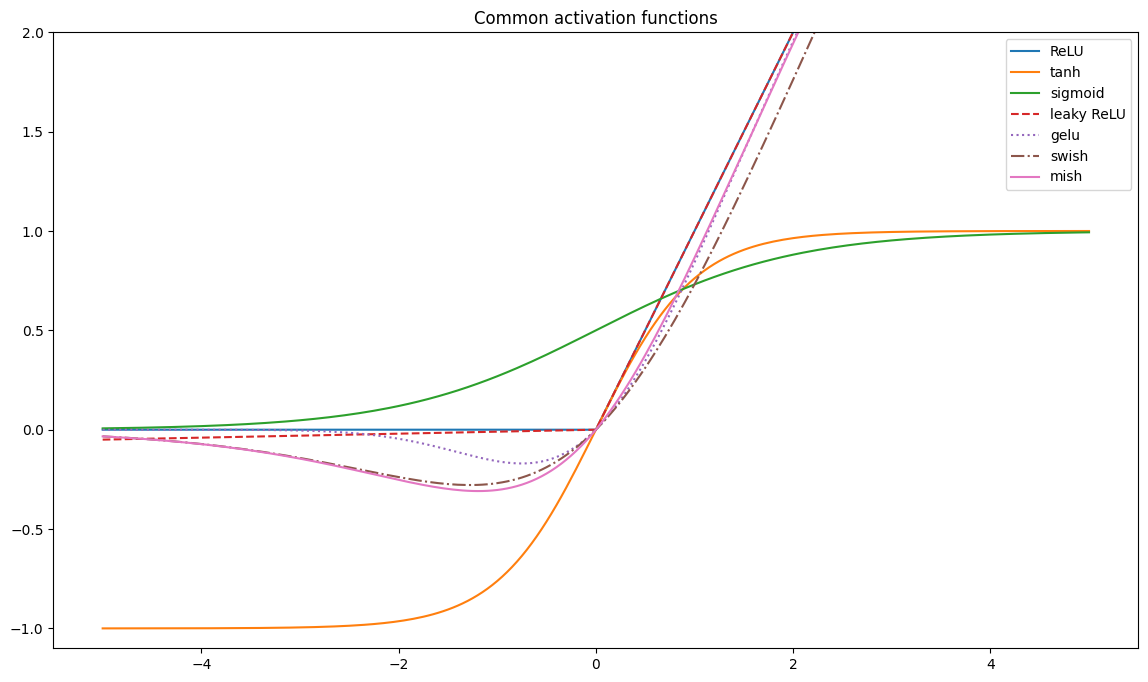

In [25]:
rng = torch.arange(-5, 5.01, 0.05)
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(rng, F.relu(rng), label='ReLU')
ax.plot(rng, torch.tanh(rng), label='tanh')
ax.plot(rng, torch.sigmoid(rng), label='sigmoid')
ax.plot(rng, F.leaky_relu(rng, negative_slope=0.01), ls='--', label='leaky ReLU')
ax.plot(rng, F.gelu(rng), ls=':', label='gelu')
ax.plot(rng, F.silu(rng), ls='dashdot', label='swish')
ax.plot(rng, F.mish(rng), label='mish')
ax.set_ylim(-1.1, 2)
ax.set_title('Common activation functions')
ax.legend()

a menos que nuestras salidas y entradas, valores esten entre -2 y 2 es mejor no usar sigmoid o tanh porque si la salida es 5 o 100 o lo que sea la salida va a ser cero porque su pendiente es plana esta saturada, su derivada es cero

In [26]:
rng = torch.arange(-1, 1, .2)

In [27]:
rng

tensor([-1.0000e+00, -8.0000e-01, -6.0000e-01, -4.0000e-01, -2.0000e-01,
         5.5511e-17,  2.0000e-01,  4.0000e-01,  6.0000e-01,  8.0000e-01])

In [28]:
rng.max(torch.tensor(0.))   #Simular el comportamiento de RELu, si es menor que cero entonces output=0

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.5511e-17,
        2.0000e-01, 4.0000e-01, 6.0000e-01, 8.0000e-01])

In [29]:
F.relu(rng)

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.5511e-17,
        2.0000e-01, 4.0000e-01, 6.0000e-01, 8.0000e-01])

In [30]:
nn.ReLU()(rng)

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.5511e-17,
        2.0000e-01, 4.0000e-01, 6.0000e-01, 8.0000e-01])

One problem with RELU is that units can 'die'. once a unit starts outputting zeros, it won`t get any additional updates and effectively dies. This is solved by adding a 'leak'. This way, even activations below zero continue to receive updates. This activation is also pretty simple and fast, implemented below

In [31]:
leak = 0.1

In [32]:
rng.max(rng * leak)

tensor([-1.0000e-01, -8.0000e-02, -6.0000e-02, -4.0000e-02, -2.0000e-02,
         5.5511e-17,  2.0000e-01,  4.0000e-01,  6.0000e-01,  8.0000e-01])

In [33]:
F.leaky_relu(rng, leak)

tensor([-1.0000e-01, -8.0000e-02, -6.0000e-02, -4.0000e-02, -2.0000e-02,
         5.5511e-17,  2.0000e-01,  4.0000e-01,  6.0000e-01,  8.0000e-01])

In [34]:
nn.LeakyReLU(leak)(rng)

tensor([-1.0000e-01, -8.0000e-02, -6.0000e-02, -4.0000e-02, -2.0000e-02,
         5.5511e-17,  2.0000e-01,  4.0000e-01,  6.0000e-01,  8.0000e-01])

Batch Normalization

What if we could guarantee that the inputs & outputs of each layer were distributed in a way that improved training? That's what batch normalization does. Let's go through what the BatchNorm layer does.

We'll start with some fake activations, and go through what BatchNorm is doing.

In [35]:
activations = torch.tensor(np.random.normal(loc=1.5, scale=7, size=(10, 5)))
activations

tensor([[ 10.6387,  -5.5279,  12.9292,   2.1236,  -3.8989],
        [  3.2275,   2.6585,  -5.9071,   2.3835,  -7.8607],
        [  0.9869,  10.4966,   7.3464,   8.1538,   7.8879],
        [  0.9320,   3.2163,   2.5945,   1.7223,  -0.9273],
        [ -1.1482,  -1.9328,   3.4947,   4.9398,   3.4151],
        [  2.4046,  10.9367,  -5.4605,  -1.9061,   6.5798],
        [-10.6181,  -3.7300,   5.3340,   5.2470,   3.2533],
        [  5.6035,  -4.1787,   1.5699,   8.0888,  -9.5760],
        [ -4.5482,  -5.9693,   3.4790,  -8.0291,   0.0872],
        [-11.3737,   6.7207,   1.6051,  -2.4081,  -3.1394]],
       dtype=torch.float64)

First, each batch, we calculate the mean and standard deviation of that batch.

In [36]:
ub = activations.mean(dim=0)    #mean accross columns. If dim=1 would be mean accross rows
ub

tensor([-0.3895,  1.2690,  2.6985,  2.0316, -0.4179], dtype=torch.float64)

https://linuxhint.com/pytorch-mean/

Next, we calculate the variance [Math Error] of the batch.

In [37]:
vb = activations.var(dim=0)
vb

tensor([47.2462, 41.9520, 30.8406, 25.5144, 33.9367], dtype=torch.float64)

Then we scale and zero-center the batch by subtracting the mean and dividing by the standard deviation. To avoid division by really small numbers, we'll add an epsilon [Math Error], generally 1e-5, to the variance before taking the square root.

In [38]:
xhat = (activations - ub) / torch.sqrt(vb + 1e-5)
xhat

tensor([[ 1.6044, -1.0494,  1.8422,  0.0182, -0.5975],
        [ 0.5262,  0.2145, -1.5496,  0.0697, -1.2776],
        [ 0.2002,  1.4247,  0.8369,  1.2120,  1.4258],
        [ 0.1923,  0.3006, -0.0187, -0.0612, -0.0874],
        [-0.1104, -0.4943,  0.1434,  0.5758,  0.6580],
        [ 0.4065,  1.4926, -1.4692, -0.7796,  1.2012],
        [-1.4881, -0.7718,  0.4746,  0.6366,  0.6302],
        [ 0.8719, -0.8411, -0.2032,  1.1992, -1.5721],
        [-0.6050, -1.1175,  0.1405, -1.9917,  0.0867],
        [-1.5980,  0.8417, -0.1969, -0.8789, -0.4672]], dtype=torch.float64)

In [39]:
# Check that the mean of each "feature" is close to zero
np.allclose(xhat.mean(dim=0), 0)

True

Now comes the cool part! There are two parameters in batch norm: gamma [Math Error] - the scale parameter, and beta [Math Error] - the shift parameter. Through training, the model actually learns what the best scale and shift for each layer are.

For our case, we're just going to make up random tensors for the scale and shift parameters, but in practice these will be learned.

In [40]:
scale = torch.tensor(np.random.normal(loc=0.1, scale=1.2, size=(5)))
shift = torch.tensor(np.random.normal(loc=0.1, scale=1.2, size=(5)))

Finally, we perform element-wise multiplication with [Math Error] by [Math Error] and add [Math Error].

In [41]:
outputs = xhat * scale + shift
outputs

tensor([[ 1.6827, -1.3358,  1.2646, -0.0829, -2.0401],
        [-0.4596, -2.5909,  1.0295, -0.2854, -1.7528],
        [-1.1072, -3.7925,  1.1949, -4.7807, -2.8950],
        [-1.1231, -2.6764,  1.1356,  0.2297, -2.2557],
        [-1.7243, -1.8870,  1.1468, -2.2768, -2.5706],
        [-0.6974, -3.8600,  1.0350,  3.0563, -2.8001],
        [-4.4616, -1.6114,  1.1698, -2.5162, -2.5589],
        [ 0.2272, -1.5426,  1.1228, -4.7300, -1.6284],
        [-2.7071, -1.2681,  1.1466,  7.8263, -2.3292],
        [-4.6800, -3.2136,  1.1233,  3.4474, -2.0952]], dtype=torch.float64)

We've basically just done the forward pass for nn.BatchNorm1d. One consideration with batch norm is that at testing or inference time, batch statistics may not be reliable. We may only be predicting on one sample, batches may be too small to calculate stable standard deviaitons, or samples may not be independent. The torch implementations of batch norm will keep a moving average of the layer's means and standard deviations to be used as the [Math Error] and [Math Error] at inference time.